In [ ]:
# default_exp core

# Public data food analysis

> Process collected data.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
from datetime import date 
from datetime import datetime
from collections import defaultdict 
import nltk
nltk.download('words', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words

import re
import string
import pkg_resources

In [ ]:
#export
def universal_key(in_path):
    """
    Description:\n
        This is a helper function that converts pickle and csv file into a pd dataframe.\n
    
    Input:\n
        - in_path(str, pandas df): input path, csv or pickle file\n
    
    Output:\n
        - df : dataframe format of the in_path file.\n
        
    """
    
    if isinstance(in_path, str):
        if in_path.split('.')[-1] == 'pickle':
            # load data
            pickle_file = open(in_path, 'rb')
            df = pickle.load(pickle_file)
            print('read the pickle file successfully.')
        if in_path.split('.')[-1] == 'csv':
            df = pd.read_csv(in_path)
            print('read the csv file successfully.')
    else:
        df = in_path
        
    return df

In [ ]:
universal_key('data/test_food_details.csv').head(2)

read the csv file successfully.


,Unnamed: 0,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,foodimage_file_name
0,1340147,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,NaN
1,1340148,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,NaN


In [ ]:
#export
def find_date(in_path, col, h=0):
    """
    Description:\n
        Extract date information from a column and shift each date in the column by h hours. (Day starts h hours early if h is negative and h hours late if h is positive)\n
        
    Input:\n
        - in_path(str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - col(str) : column that contains the information of date and time, which is 24 hours system.
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts and ends 4 hours later than normal.
        
    Return:\n
        - a pandas series represents the date extracted from col.\n

    Requirements:\n
        Elements in col should be pd.datetime objects
            
    """
    df = universal_key(in_path)
    
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object".format(col))
        
    def find_date(d, h):
        if h > 0:
            if d.hour < h:
                return d.date() - pd.Timedelta('1 day')
        if h < 0:
            if d.hour+1 > (24+h):
                return d.date() + pd.Timedelta('1 day')
        return d.date()
    return df[col].apply(find_date, args=([h]))

In [ ]:
df = universal_key('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])
df['date'] = find_date(df, 'original_logtime')
df[['original_logtime', 'date']].head(3)

read the csv file successfully.


,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-09
2,2017-12-09 00:58:00+00:00,2017-12-09


In [ ]:
df['date'] = find_date(df, 'original_logtime', 4)
df[['original_logtime', 'date']].head(3)
# last two rows shift one day earlier due to that a day starts at 4 

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-08
2,2017-12-09 00:58:00+00:00,2017-12-08


In [ ]:
df['date'] = find_date(df, 'original_logtime', -4)
df[['original_logtime', 'date']].head(5)
# last two rows shift one day later due to that a day ends at 20

,original_logtime,date
0,2017-12-08 17:30:00+00:00,2017-12-08
1,2017-12-09 00:01:00+00:00,2017-12-09
2,2017-12-09 00:58:00+00:00,2017-12-09
3,2018-02-22 21:52:00+00:00,2018-02-23
4,2018-02-22 22:53:00+00:00,2018-02-23


In [ ]:
#export
def find_float_time(in_path, col, h=0):
    """
    Description:\n
        Extract time information from a column and shift each time by h hours. (Day starts h hours early if h is negative and h hours late if h is positive)\n
        
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - col(str) : column that contains the information of date and time that's 24 hours system.
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts at 4 and ends at 28. When h = -4, everyday starts at -4 and ends at 20.
        
    Return:\n
        - a pandas series represents the date extracted from col.\n

    Requirements:\n
        Elements in col should be pd.datetime objects
            
    """
    df = universal_key(in_path)
    if df[col].dtype == 'O':
        raise TypeError("'{}' column must be converted to datetime object firsly".format(col))
    local_time = df[col].apply(lambda x: pd.Timedelta(x.time().isoformat()).total_seconds() /3600.)
    if h > 0:
        local_time = np.where(local_time < h, 24+ local_time, local_time)
        return pd.Series(local_time)
    if h < 0:
        local_time = np.where(local_time > (24+h), local_time-24., local_time)
        return pd.Series(local_time)
    return local_time
    

In [ ]:
df = universal_key('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

read the csv file successfully.


In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime')
df[['original_logtime', 'float_time']].head(3)

,original_logtime,float_time
0,2017-12-08 17:30:00+00:00,17.500000
1,2017-12-09 00:01:00+00:00,0.016667
2,2017-12-09 00:58:00+00:00,0.966667


In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime', 4)
df['date'] = find_date(df, 'original_logtime', 4)
df[['original_logtime','date', 'float_time']].head(3)
# last two rows shift one day earlier due to that a day starts at 4 and ends at 28

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-08,24.016667
2,2017-12-09 00:58:00+00:00,2017-12-08,24.966667


In [ ]:
df['float_time'] = find_float_time(df, 'original_logtime', -4)
df['date'] = find_date(df, 'original_logtime', -4)
df[['original_logtime','date', 'float_time']].head(5)
# last two rows shift one day later and local_time starts at -4 and ends at 20

,original_logtime,date,float_time
0,2017-12-08 17:30:00+00:00,2017-12-08,17.500000
1,2017-12-09 00:01:00+00:00,2017-12-09,0.016667
2,2017-12-09 00:58:00+00:00,2017-12-09,0.966667
3,2018-02-22 21:52:00+00:00,2018-02-23,-2.133333
4,2018-02-22 22:53:00+00:00,2018-02-23,-1.116667


In [ ]:
#export
def week_from_start(in_path, col, identifier):
        """
        Description:\n
            Calculate the number of weeks for each logging since the first day of the logging for each participant(identifier).
        Input:\n
            - in_path (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
            - col (str): column name that contains date informaiton from the in_path dataframe.
            - identifier (str): unique_id or ID, or name that identifies people.

        Return:\n
            - a numpy array represents the date extracted from col.\n
        """
        
        df = universal_key(in_path)
        if 'date' not in df.columns:
            raise NameError("There must exist a 'date' column.")
        # Handle week from start
        df_dic = dict(df.groupby(identifier).agg(np.min)[col])

        def count_week_public(s):
            return (s.date - df_dic[s[identifier]]).days // 7 + 1
    
        return df.apply(count_week_public, axis = 1)

In [ ]:
df = universal_key('data/test_food_details.csv')
df['original_logtime'] = pd.to_datetime(df['original_logtime'])

read the csv file successfully.


In [ ]:
# date column is a pre-requisite
df['date'] = find_date(df, 'original_logtime')
df['week_from_start'] = week_from_start(df, 'date', 'unique_code')
df[['unique_code','original_logtime','week_from_start']][2:4]

,unique_code,original_logtime,week_from_start
2,alqt14018795225,2017-12-09 00:58:00+00:00,1
3,alqt14018795225,2018-02-22 21:52:00+00:00,11


In [ ]:
#export
def load_public_data(in_path, h):
    """
    Description:\n
        Load original public data and output processed data in pickle format.\n
    
        Process includes:\n
        1. Dropping 'foodimage_file_name' column.\n
        2. Handling the format of time by deleting am/pm by generating a new column, 'original_logtime_notz'\n
        3. Generating the date column with possible hour shifts, 'date'\n
        4. Converting time into float number into a new column with possible hour shifts, 'local_time'\n
        5. Converting time to a format of HH:MM:SS, 'time'\n
        6. Generating the column 'week_from_start' that contains the week number that the participants input the food item.\n
        7. Generating 'year' column based on the input data.\n

    Input:\n
        - in_path (str, pandas df): input path, csv file\n
        - h(int) : hours to shift the date. For example, when h = 4, everyday starts and ends 4 hours later than normal.
        
    Output:\n
        - public_all: the processed dataframe\n

    Requirements:\n
        in_path file must have the following columns:\n
            - foodimage_file_name\n
            - original_logtime\n
            - date\n
            - unique_code\n
    """
    public_all = universal_key(in_path).drop(columns = ['foodimage_file_name'])
    
    def handle_public_time(s):
        """
        helper function to get rid of am/pm in the end of each time string
        """
        tmp_s = s.replace('p.m.', '').replace('a.m.', '')
        try:
            return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
        except:
            try:
                if int(tmp_s.split()[1][:2]) > 12:
                    tmp_s = s.replace('p.m.', '').replace('a.m.', '').replace('PM', '').replace('pm', '')
                return pd.to_datetime(' '.join(tmp_s.split()[:2]) )
            except:
                return np.nan

    public_all['original_logtime_notz'] = public_all['original_logtime'].apply(handle_public_time)
    
    public_all = public_all.dropna().reset_index(drop = True)
    

    public_all['date'] = find_date(public_all, 'original_logtime_notz', h)
    
    
    # Handle the time - Time in floating point format
    
    public_all['local_time'] = find_float_time(public_all, 'original_logtime_notz', h)
    
    # Handle the time - Time in Datetime object format
    public_all['time'] = pd.DatetimeIndex(public_all.original_logtime_notz).time
    
    # Handle week from start
    public_all['week_from_start'] = week_from_start(public_all,'date','unique_code')
    
    public_all['year'] = public_all.date.apply(lambda d: d.year)
    
    return public_all

In [ ]:
load_public_data('data/test_food_details.csv', h=4).head(2)

read the csv file successfully.


,Unnamed: 0,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,date,local_time,time,week_from_start,year
0,1340147,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,1340148,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
# export
def filtering_usable_data(df, identifier, date_col, num_items, num_days):
    '''
    Description:\n
        This function filters the cleaned app data so the users who satisfies the criteria are left. The criteria is that the person is left if the total loggings for that person are more than num_items and at the same time, the total days for loggings are more than num_days.\n
    Input:\n
        - df (pd.DataFrame): the dataframe to be filtered\n
        - identifier (str): unique_id or ID, or name that identifies people.
        - date_col (str): column name that contains date informaiton from the df dataframe.
        - num_items (int):   number of items to be used as cut-off\n
        - num_days (int):    number of days to be used as cut-off\n
    Output:\n
        - df_usable:         a panda DataFrame with filtered rows\n
        - set_usable:        a set of unique_code to be included as "usable"\n
    Side Effects:\n
        None\n
    Requirements:\n
        df should have the following columns:\n
            - desc_text\n
    Used in:\n
        Analysis pipeline\n
    '''
    print(' => filtering_usable_data()')
    print('  => using the following criteria:', num_items, 'items and', num_days, 'days.')

    # Item logged
    log_item_count = df.groupby(identifier).agg('count')[['desc_text']].rename(columns = {'desc_text': 'Total Logged'})

    # Day counts
    log_days_count = df[[identifier, date_col]]\
        .drop_duplicates().groupby(identifier).agg('count').rename(columns = {date_col: 'Day Count'})

    item_count_passed = set(log_item_count[log_item_count['Total Logged'] >= num_items].index)
    day_count_passed = set(log_days_count[log_days_count['Day Count'] >= num_days].index)

    print('  => # of public users pass the criteria:', end = ' ')
    print(len(item_count_passed & day_count_passed))
    passed_participant_set = item_count_passed & day_count_passed
    df_usable = df.loc[df.unique_code.apply(lambda c: c in passed_participant_set)]\
        .copy().reset_index(drop = True)
    # print('  => Now returning the pd.DataFrame object with the head like the following.')
    # display(df_usable.head(5))
    return df_usable, set(df_usable.unique_code.unique())

In [ ]:
df = universal_key('data/output/public.pickle')
df.shape

read the pickle file successfully.


(6854, 13)

In [ ]:
filtering_usable_data(df,'unique_code','date', 1000, 14)[0].shape

 => filtering_usable_data()
  => using the following criteria: 1000 items and 14 days.
  => # of public users pass the criteria: 2


(3271, 13)

In [ ]:
#export
def prepare_baseline_and_intervention_usable_data(in_path, identifier, date_col, baseline_num_items, baseline_num_days, intervention_num_items, intervention_num_days):
    """
    Description:\n
        Filter and create baseline_expanded and intervention groups based on in_path pickle file. Expanded baseline dataset contains the first two weeks data and 13, 14 weeks data that pass the given criteria. Intervention dataset contains 13, 14 weeks data that pass the given criteria.\n
        
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or pandas dataframe format\n
        - identifier (str): unique_id or ID, or name that identifies people.
        - date_col (str): column name that contains date informaiton from the df dataframe.
        - baseline_num_items (int): number of items to be used as cut-off for baseline group. \n
        - baseline_num_days (int): number of days to be used as cut-off for baseline group. \n
        - intervention_num_items (int): number of items to be used as cut-off for intervention group.\n
        - intervention_num_days (int): number of days to be used as cut-off for intervention group. \n
        
    Return:\n
        - a list in which index 0 is the baseline expanded dataframe and 1 is the intervention dataframe.\n

    Requirements:\n
        in_path file must have the following columns:\n
            - week_from_start\n
            - desc_text\n
    """
    
    
    public_all = universal_key(in_path)
    
    # create baseline data
    df_public_baseline = public_all.query('week_from_start <= 2')
    df_public_baseline_usable, public_baseline_usable_id_set = \
    filtering_usable_data(df_public_baseline,identifier, date_col, num_items = baseline_num_items, num_days = baseline_num_days)
    
    # create intervention data
    df_public_intervention = public_all.query('week_from_start in [13, 14]')
    df_public_intervention_usable, public_intervention_usable_id_set = \
    filtering_usable_data(df_public_intervention,identifier, date_col, num_items = intervention_num_items, num_days = intervention_num_days)
    
    # create df that contains both baseline and intervention id_set that contains data for the first two weeks
    expanded_baseline_usable_id_set = set(list(public_baseline_usable_id_set) + list(public_intervention_usable_id_set))
    df_public_basline_usable_expanded = public_all.loc[public_all.apply(lambda s: s.week_from_start <= 2 \
                                                    and s.unique_code in expanded_baseline_usable_id_set, axis = 1)]
        
    return [df_public_basline_usable_expanded, df_public_intervention_usable]

In [ ]:
df= prepare_baseline_and_intervention_usable_data('data/output/public.pickle','unique_code','date', 20, 10, 40, 12)[0]
df.head(2)

read the pickle file successfully.
 => filtering_usable_data()
  => using the following criteria: 20 items and 10 days.
  => # of public users pass the criteria: 9
 => filtering_usable_data()
  => using the following criteria: 40 items and 12 days.
  => # of public users pass the criteria: 3


,Unnamed: 0,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,date,local_time,time,week_from_start,year
0,1340147,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017
1,1340148,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017


In [ ]:
df.shape

(1222, 13)

In [ ]:
#export
def in_good_logging_day(in_path, identifier='unique_code', time_col='local_time', min_log_num = 2, min_seperation = 4):
    """
    Description:\n
        A logging's in a good logging day if the there are more than min_log_num loggings in one day w/ more than min_seperation hoursx apart from the earliest logging and the latest logging and False otherwise.\n
        
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or pandas dataframe format.\n
        - identifier (str): id-like column that's used to identify a subject.\n
        - time_col (str): column that contains time in float format.\n
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.\n
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.\n
        
    Return:\n
        - A boolean numpy array indicating whether the corresponding row is in a good logging day. Details on the criteria is in the description.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - unique_code\n
            - local_time\n
            - date\n

    """
    def adherent(s):
        if len(s.values) >= min_log_num and (max(s.values) - min(s.values)) >= min_seperation:
            return True
        else:
            return False
        
    df = universal_key(in_path)
    
    adherent_dict = dict(df.groupby([identifier, 'date'])[time_col].agg(adherent))

    
    return df.apply(lambda x: adherent_dict[(x[identifier], x.date)], axis = 1)

In [ ]:
df = load_public_data('data/test_food_details.csv', 4)
df['in_good_logging_day'] = in_good_logging_day(df)
df.head(2)

read the csv file successfully.


,Unnamed: 0,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,date,local_time,time,week_from_start,year,in_good_logging_day
0,1340147,7572733,alqt14018795225,150,Water,w,2017-12-08 17:30:00+00:00,2017-12-08 17:30:00+00:00,2017-12-08,17.500000,17:30:00,1,2017,True
1,1340148,411111,alqt14018795225,150,Coffee White,b,2017-12-09 00:01:00+00:00,2017-12-09 00:01:00+00:00,2017-12-08,24.016667,00:01:00,1,2017,True


In [ ]:
#export
def most_active_user(in_path, food_type = ["f", "b", "m", "w"]):
    """
    Description:\n
        This function returns a dataframe reports the number of good logging days for each user in the in_path file. The default order is descending.\n
        
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or pandas dataframe format.\n
        - food_type (str): food types to filter in a list format. Default: ["f", "b", "m", "w"]. Available food types:\n
            1. 'w' : water \n
            2. 'b' : beverage \n
            3. 'f' : food \n
            4. 'm' : medicine \n
        
    Return:\n
        - A dataframe contains the number of good logging days for each user.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
            - unique_code\n
            - date\n
    
    """

    public_all = universal_key(in_path)
    
    # filter the dataframe so it only contains input food type
    
    filtered_users = public_all.query('food_type in @food_type')
    
    filtered_users['in_good_logging_day'] = in_good_logging_day(filtered_users)
    
    public_top_users_day_counts = pd.DataFrame(filtered_users.query('in_good_logging_day == True')\
                            [['date', 'unique_code']].groupby('unique_code')['date'].nunique())\
                            .sort_values(by = 'date', ascending = False).rename(columns = {'date': 'day_count'})

    
    return public_top_users_day_counts

In [ ]:
most_active_user('data/output/public.pickle').head(2)

In [ ]:
most_active_user('data/output/public.pickle', ['f','b']).head(2)

In [ ]:
# export 
def convert_loggings(in_path):
    """
    Description:\n
       This function convert all the loggings in the in_path file into a list of individual items based on the desc_text column. This function is based on a built-in vocabulary dictionary and an n-gram searcher.\n
       
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        
    Return:\n
        - A dataframe contains the cleaned version of the desc_text.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
            - desc_text\n

    """

    public_all = universal_key(in_path)
    
    # initialize food parser instance
    fp = FoodParser()
    fp.initialization()
    
    # parse food
    parsed = [fp.parse_food(i, return_sentence_tag = True) for i in public_all.desc_text.values]
    
    public_all_parsed = pd.DataFrame({
    'ID': public_all.unique_code,
    'food_type': public_all.food_type,
    'desc_text': public_all.desc_text,
    'cleaned': parsed
    })
    
    public_all_parsed['cleaned'] = public_all_parsed['cleaned'].apply(lambda x: x[0])
    
    
    return public_all_parsed

In [ ]:
# convert_loggings('data/output/public.pickle').head(3)

In [ ]:
# export
def get_types(in_path, food_type):
    """
    Description:\n
       This function filters with the expected food types and return a cleaner version of in_path file.\n 
       
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - food_type (str): expected types of the loggings for filtering, in format of list. Available types:  \n
            1. 'w' : water \n
            2. 'b' : beverage \n
            3. 'f' : food \n
            4. 'm' : medicine \n
        
    Return:\n
        - A filtered dataframe with expected food type/types with five columns: 'unique_code','food_type', 'desc_text', 'date', 'local_time'.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
            - desc_text\n
            - unique_code\n
            - desc_text\n
            - date\n
            - local_time\n
            
    """
    
    df = universal_key(in_path)
        
    if len(food_type) == 0:
        return df
    
    if len(food_type) == 1:
        if food_type[0] not in ['w', 'b', 'f', 'm']:
            raise Exception("not a valid logging type")
        filtered = df[df['food_type']==food_type[0]]
    else:  
        filtered = df[df['food_type'].isin(food_type)]
        
    
    return filtered
        

In [ ]:
get_types('data/output/public_basline_usable_expanded.pickle',['w', 'f'])[['unique_code','desc_text','food_type']].head(3)

In [ ]:
df = load_public_data('data/test_food_details.csv')
get_certain_types(df, ['m'])[['unique_code','desc_text','food_type']].head(3)

In [ ]:
#export
def eating_intervals_percentile(in_path, time_col, identifier):
    """
    Description:\n
       This function calculates the .025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975 quantile of eating time and mid 95%, mid 90%, mid 80%, mid 75% and mid 50% duration for each user.\n 
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - time_col(str) : the column that represents the eating time
        - identitfier(str) : participants' unique identifier such as id, name, etc
        
    Return:\n
        - A summary table with count, mean, std, min, quantiles and mid durations for all subjects from the in_path file.\n
        
            
    """
    
    df = universal_key(in_path)
    
    ptile = df.groupby(identifier)[time_col].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])
    ll = ['2.5%','5%','10%','12.5%','25%']
    ul = ['97.5%','95%', '90%','87.5%', '75%']
    mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
    for low, upp, midp in zip(ll,ul,mp):
        ptile[midp] = ptile[upp] - ptile[low]
        
    return ptile

In [ ]:
df = load_public_data('data/test_food_details.csv',4)
eating_intervals_percentile(df, 'local_time', 'unique_code').iloc[:2]

read the csv file successfully.


,count,mean,std,min,2.5%,5%,10%,12.5%,25%,50%,...,87.5%,90%,95%,97.5%,max,duration mid 95%,duration mid 90%,duration mid 80%,duration mid 75%,duration mid 50%
unique_code,,,,,,,,,,,,,,,,,,,,,
alqt1148284857,149.0,12.266890,5.630092,4.0,4.535000,4.816667,5.713333,6.250000,8.516667,11.600000,...,17.341667,17.673333,26.813333,27.171667,27.933333,22.636667,21.996667,11.96,11.091667,7.333333
alqt14018795225,488.0,18.489993,7.710772,4.0,4.183333,4.350000,4.733333,4.877083,16.737500,20.441667,...,26.412500,26.903333,27.438333,27.600000,27.966667,23.416667,23.088333,22.17,21.535417,7.662500


In [ ]:
#export
def summarize_data(in_path, float_time_col, identifier, min_log_num = 2, min_seperation = 4):
    """
    Description:\n
       This function calculates num_days, num_total_items, num_f_n_b, num_medications, num_water, duration_mid_95, start_95, end_95, breakfast_avg, breakfast_std, dinner_avg, dinner_std, eating_win_avg, eating_win_std, adherent_count, breakfast variation (90%-10%), dinner variation (90%-10%).\n 
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - float_time_col(str) : the column that represents the eating time
        - identitfier(str) : participants' unique identifier such as id, name, etc
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.\n
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.\n
        
    Return:\n
        - A summary table with count, mean, std, min, quantiles and mid durations for all subjects from the in_path file.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
            - date\n
  
    """
    df = universal_key(in_path)
    
    #num_days
    num_days = df.groupby(identifier).date.nunique()

    #num_total_items
    num_total_items = df.groupby(identifier).count().iloc[:,0]

    #num_f_n_b
    num_f_n_b = get_types(df, ['f','b']).groupby(identifier).count().iloc[:,0]

    #num_medications
    num_medications = get_types(df, ['m']).groupby(identifier).count().iloc[:,0]

    #num_water
    num_water = get_types(df, ['w']).groupby(identifier).count().iloc[:,0]

    #duration_mid_95, start_95, end_95
    eating_intervals = eating_intervals_percentile(df, float_time_col, identifier)[['2.5%','95%','duration mid 95%']]

    #breakfast_avg
    breakfast_avg = df.groupby([identifier, 'date'])[float_time_col].min().groupby(identifier).mean()

    #breakfast_std
    breakfast_std = df.groupby([identifier, 'date'])[float_time_col].min().groupby(identifier).std()

    #dinner_avg
    dinner_avg = df.groupby([identifier, 'date'])[float_time_col].max().groupby(identifier).mean()

    #dinner_std
    dinner_std = df.groupby([identifier, 'date'])[float_time_col].max().groupby(identifier).std()

    #eating_win_avg
    eating_win_avg = dinner_avg - breakfast_avg

    #eating_win_std
    eating_win_std = dinner_std - breakfast_std

    #good_logging_count
    df['in_good_logging_day'] = in_good_logging_day(df, min_log_num=min_log_num, min_seperation=min_seperation)
    good_logging_count = df.groupby(identifier)['in_good_logging_day'].sum()

    #breakfast variation (90%-10%)
    breakfast_variability = breakfast_analysis_variability(df, plot=False).set_index('id')
    breakfast_ser = breakfast_variability['90%'] - breakfast_variability['10%']

    #dinner variation (90%-10%)
    dinner_variability = dinner_analysis_variability(df, plot=False).set_index('id')
    dinner_ser = dinner_variability['90%'] - dinner_variability['10%']

    returned = pd.concat([num_days, num_total_items, num_f_n_b, num_medications, num_water, breakfast_avg, breakfast_std, dinner_avg, dinner_std, eating_win_avg, eating_win_std, good_logging_count, breakfast_ser, dinner_ser], axis=1).reset_index()
    returned.columns = [identifier,'num_days', 'num_total_items', 'num_f_n_b', 'num_medications', 'num_water', 'breakfast_avg', 'breakfast_std', 'dinner_avg', 'dinner_std', 'eating_win_avg', 'eating_win_std', 'good_logging_count', 'breakfast variation (90%-10%)', 'dinner variation (90%-10%)']
    returned = returned.merge(eating_intervals, on = identifier, how='left').fillna(0)
    
    returned['num_medications'] = returned['num_medications'].astype('int')
    returned['num_water'] = returned['num_water'].astype('int')
    
    return returned

    
    
    

In [ ]:
df = load_public_data('data/test_food_details.csv',4)
summarize_data(df, 'local_time', 'unique_code')

read the csv file successfully.


,unique_code,num_days,num_total_items,num_f_n_b,num_medications,num_water,breakfast_avg,breakfast_std,dinner_avg,dinner_std,eating_win_avg,eating_win_std,good_logging_count,breakfast variation (90%-10%),dinner variation (90%-10%),2.5%,95%,duration mid 95%
0,alqt1148284857,13,149,96,19,34,7.821795,6.710717,23.485897,4.869082,15.664103,-1.841635,146,2.966667,9.666667,4.535000,26.813333,22.636667
1,alqt14018795225,64,488,484,3,1,7.525781,5.434563,25.858594,3.374839,18.332813,-2.059723,484,13.450000,3.100000,4.183333,27.438333,23.416667
2,alqt16675467779,111,739,466,0,273,5.656757,3.514652,26.222673,0.965179,20.565916,-2.549474,722,2.053333,2.303333,4.000000,27.000000,23.000000
3,alqt21525720972,92,989,687,0,302,11.241486,3.549328,23.348007,3.331940,12.106522,-0.217388,986,9.250000,7.750000,6.833333,24.576667,18.788333
4,alqt45631586569,233,605,582,0,23,14.690558,5.362661,23.093705,4.629802,8.403147,-0.732859,512,12.336667,9.273333,5.900000,27.396667,21.581667
5,alqt5833085442,22,137,69,0,68,9.170455,2.001950,20.778030,1.009576,11.607576,-0.992374,137,4.213333,1.890000,7.266667,21.066667,14.346667
6,alqt62359040167,39,129,129,0,0,7.252137,3.306471,23.850427,5.204685,16.598291,1.898214,127,3.566667,12.570000,4.723333,26.960000,22.490000
7,alqt6695047873,41,347,262,78,7,7.763008,5.381072,21.281707,6.529401,13.518699,1.148329,329,4.240000,11.393333,4.500000,27.406667,23.000000
8,alqt78896444285,87,1110,506,117,487,5.259770,0.762313,18.062452,3.478156,12.802682,2.715843,1091,1.630000,5.633333,4.778750,19.259167,15.309167
9,alqt8668165687,137,2161,1322,0,839,8.256569,1.903419,23.172263,2.144410,14.915693,0.240991,2161,4.086667,5.860000,7.550000,22.950000,16.083333


In [ ]:
# export
def breakfast_analysis_summary(in_path, identifier, date_col, time_col,min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days and calculate the 5%,10%,25%,50%,75%,90%,95% quantile of breakfast time for each user.\n 
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.
        
        
    Return:\n
        - A summary table with 5%,10%,25%,50%,75%,90%,95% quantile of breakfast time for all subjects from the in_path file.\n
        
            
    """

    df = universal_key(in_path)
        
    # leave only the loggings in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    breakfast_series = df.groupby([identifier, date_col])[time_col].min().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    breakfast_df = pd.DataFrame(breakfast_series)
    all_rows = []
    for index in breakfast_df.index:
        tmp_dict = dict(breakfast_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    breakfast_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    
    return breakfast_summary_df

In [ ]:
breakfast_analysis_summary('data/output/public_basline_usable_expanded.pickle', 'unique_code', 'date', 'local_time').head(3)


read the pickle file successfully.


,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,4.141667,4.283333,4.450000,4.783333,5.375000,7.250000,7.883333
1,alqt14018795225,17.500000,17.500000,17.500000,17.500000,17.500000,17.500000,17.500000
2,alqt16675467779,4.210833,4.393333,4.570833,5.000000,5.566667,6.086667,6.748333


In [ ]:
# export
def breakfast_analysis_variability(in_path,identifier, date_col, time_col, min_log_num=2, min_separation=4, plot=True):
    """
    Description:\n
       This function calculates the variability of loggings in good logging day by subtracting 5%,10%,25%,50%,75%,90%,95% quantile of breakfast time from the 50% breakfast time. It can also make a histogram that represents the 90%-10% interval for all subjects.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc
        - date_col(str) : the column that represents the dates
        - time_col(str) : the column that represents the float time
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.
        - plot(bool) : Whether generating a histogram for breakfast variability. Default = True.
        
    Return:\n
        - A dataframe that contains 5%,10%,25%,50%,75%,90%,95% quantile of breakfast time minus 50% time for each subjects from the in_path file.\n
        
    Requirements:\n
        in_path file must have the following columns:\n
            - unique_code\n
            - date\n
            - local_time\n
    """
    

    df = universal_key(in_path)
        
    # leave only the loggings in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    breakfast_series = df.groupby(['unique_code', 'date'])['local_time'].min().groupby('unique_code').quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    breakfast_df = pd.DataFrame(breakfast_series)
    all_rows = []
    for index in breakfast_df.index:
        tmp_dict = dict(breakfast_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    breakfast_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    breakfast_variability_df = breakfast_summary_df.copy()
    
    for col in breakfast_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        breakfast_variability_df[col] = breakfast_variability_df[col] - breakfast_variability_df['50%']
    breakfast_variability_df['50%'] = breakfast_variability_df['50%'] - breakfast_variability_df['50%']
    
    if plot == True:
    
        fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
        sns_plot = sns.distplot( breakfast_variability_df['90%'] - breakfast_variability_df['10%'] )
        ax.set(xlabel='Variation Distribution for Breakfast (90% - 10%)', ylabel='Kernel Density Estimation')
    
    return breakfast_variability_df

read the pickle file successfully.


,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,-0.641667,-0.500000,-0.333333,0.0,0.591667,2.466667,3.100000
1,alqt14018795225,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,alqt16675467779,-0.789167,-0.606667,-0.429167,0.0,0.566667,1.086667,1.748333


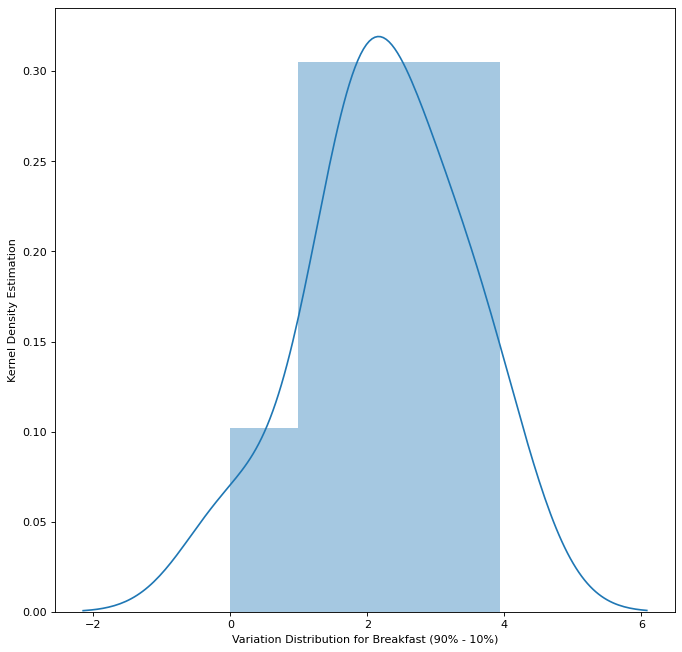

In [ ]:
breakfast_analysis_variability('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time').head(3) 


In [ ]:
#export
def breakfast_avg_histplot(in_path, identifier, date_col, time_col):
    """
    Description:\n
       This function take the first caloric event (no water or med) and calculate average event's time for “each participant”.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.

    Return:\n
        - None
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
    """
    df = universal_key(in_path)
    df = df.query('food_type in ["f", "b"]')
    breakfast_time = df.groupby([identifier, date_col])[time_col].min()
    avg_breakfast_time = breakfast_time.reset_index().groupby(identifier).mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_breakfast_time[time_col], kde = False)
    ax.set(xlabel='First Meal Time - Averaged by Person', ylabel='Frequency Count')

read the pickle file successfully.


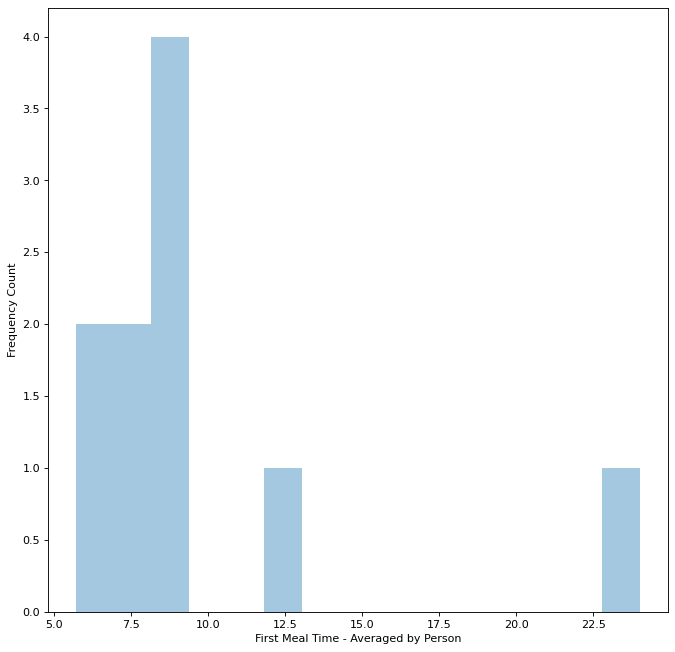

In [ ]:
breakfast_avg_histplot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
# export
def breakfast_sample_distplot(in_path, n, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the distplot for the breakfast time from n participants that will be randomly selected with replacement.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - n (int): the number of distplot in the output figure
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        
    Return:\n
        - None
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
    """
    df = universal_key(in_path)
    df = df[df['food_type'].isin(['f','b'])]
    breakfast_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].min())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(breakfast_by_person.index.droplevel(date_col)))), n):
        print(i)
        sns.distplot(breakfast_by_person[time_col].loc[i])

read the pickle file successfully.
Plotting distplots for the following users:
alqt14018795225
alqt8668165687
alqt8668165687
alqt16675467779
alqt45631586569


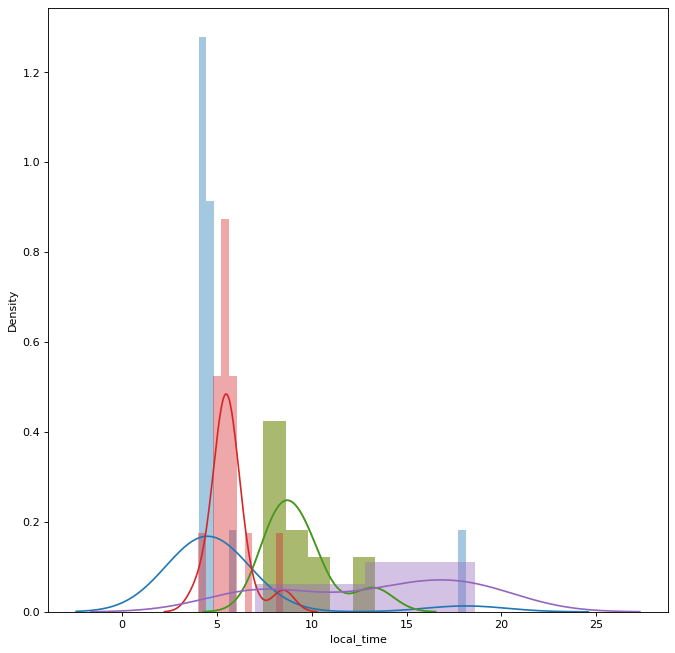

In [ ]:
breakfast_sample_distplot('data/output/public_intervention_usable.pickle',5, 'unique_code', 'date', 'local_time')

In [ ]:
# export
def dinner_analysis_summary(in_path, identifier, date_col, time_col, min_log_num=2, min_separation=4):
    """
    Description:\n
       This function takes the loggings in good logging days and calculate the 5%,10%,25%,50%,75%,90%,95% quantile of dinner time for each user.\n 
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.
        
    Return:\n
        - A summary table with 5%,10%,25%,50%,75%,90%,95% quantile of dinner time for all subjects from the in_path file.\n
        
    """
    
    df = universal_key(in_path)
        
    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    dinner_series = df.groupby([identifier, date_col])[time_col].max().groupby(identifier).quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    dinner_df = pd.DataFrame(dinner_series)
    all_rows = []
    for index in dinner_df.index:
        tmp_dict = dict(dinner_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    dinner_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)

    
    return dinner_summary_df

In [ ]:
dinner_analysis_summary('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time').head(3)

read the pickle file successfully.


,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,17.533333,17.633333,18.225000,26.966667,27.150000,27.300000,27.616667
1,alqt14018795225,24.966667,24.966667,24.966667,24.966667,24.966667,24.966667,24.966667
2,alqt16675467779,24.955000,25.000000,25.000000,26.000000,26.687500,27.475000,27.650000


In [ ]:
# export
def dinner_analysis_variability(in_path, identifier, date_col, time_col, min_log_num=2, min_separation=4, plot=True):
    """
    Description:\n
       This function calculates the variability of loggings in good logging day by subtracting 5%,10%,25%,50%,75%,90%,95% quantile of dinner time from the 50% dinner time. It also make a histogram that represents the 90%-10% interval for all subjects.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        - min_log_num (count,int): filteration criteria on the minimum number of loggings each day.
        - min_seperation(hours,int): filteration criteria on the minimum separations between the earliest and latest loggings each day.
        - plot(bool) : Whether generating a histogram for breakfast variability. Default = True.
    Return:\n
        - A dataframe that contains 5%,10%,25%,50%,75%,90%,95% quantile of dinner time minus 50% time for each subjects from the in_path file.\n
        
    """
    
    df = universal_key(in_path)
        
    # leave only the loggings that are in a good logging day
    df['in_good_logging_day'] = in_good_logging_day(df, identifier, time_col, min_log_num, min_separation)
    df = df[df['in_good_logging_day']==True]
    
    dinner_series = df.groupby(['unique_code', 'date'])['local_time'].max().groupby('unique_code').quantile([0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95])
    dinner_df = pd.DataFrame(dinner_series)
    all_rows = []
    for index in dinner_df.index:
        tmp_dict = dict(dinner_series[index[0]])
        tmp_dict['id'] = index[0]
        all_rows.append(tmp_dict)
    dinner_summary_df = pd.DataFrame(all_rows, columns = ['id', 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])\
        .rename(columns = {0.05: '5%', 0.1: '10%', 0.25: '25%', 0.5: '50%', 0.75: '75%', 0.9: '90%', 0.95: '95%'})\
        .drop_duplicates().reset_index(drop = True)
    dinner_variability_df = dinner_summary_df.copy()
    
    for col in dinner_variability_df.columns:
        if col == 'id' or col == '50%':
            continue
        dinner_variability_df[col] = dinner_variability_df[col] - dinner_variability_df['50%']
    dinner_variability_df['50%'] = dinner_variability_df['50%'] - dinner_variability_df['50%']
    
    if plot == True:
        fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
        sns_plot = sns.distplot( dinner_variability_df['90%'] - dinner_variability_df['10%'] )
        ax.set(xlabel='Variation Distribution for Dinner (90% - 10%)', ylabel='Kernel Density Estimation')
    
    return dinner_variability_df

read the pickle file successfully.


,id,5%,10%,25%,50%,75%,90%,95%
0,alqt1148284857,-9.433333,-9.333333,-8.741667,0.0,0.183333,0.333333,0.65
1,alqt14018795225,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00
2,alqt16675467779,-1.045000,-1.000000,-1.000000,0.0,0.687500,1.475000,1.65


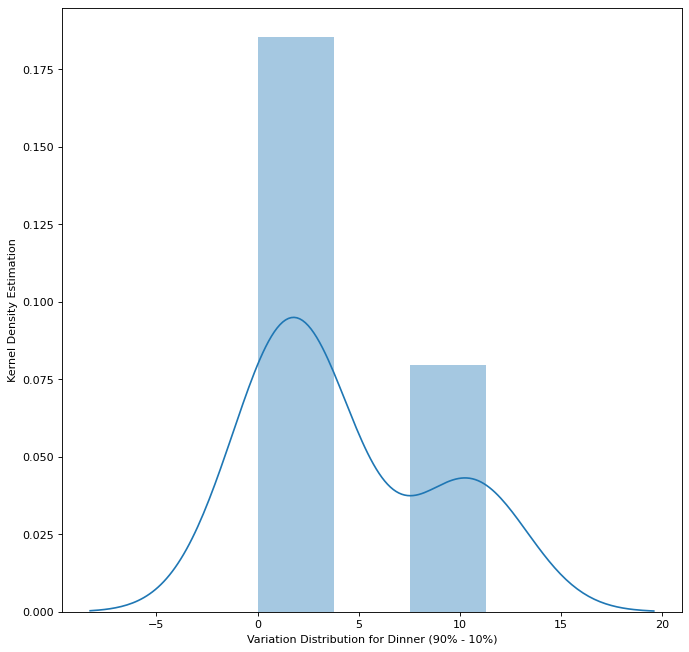

In [ ]:
dinner_analysis_variability('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time').head(3)

In [ ]:
#export
def dinner_avg_histplot(in_path, identifier, date_col, time_col):
    """
    Description:\n
       This function take the last caloric event (no water or med) and calculate average event's time for “each participant”.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.

    Return:\n
        - None
        
    Requirements:\n
            - food_type\n
    """
    df = universal_key(in_path)
    df = df.query('food_type in ["f", "b"]')
    breakfast_time = df.groupby([identifier, date_col])[time_col].max()
    avg_breakfast_time = breakfast_time.reset_index().groupby(identifier).mean()
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    sns.distplot(avg_breakfast_time[time_col], kde = False)
    ax.set(xlabel='Last Meal Time - Averaged by Person', ylabel='Frequency Count')

read the pickle file successfully.


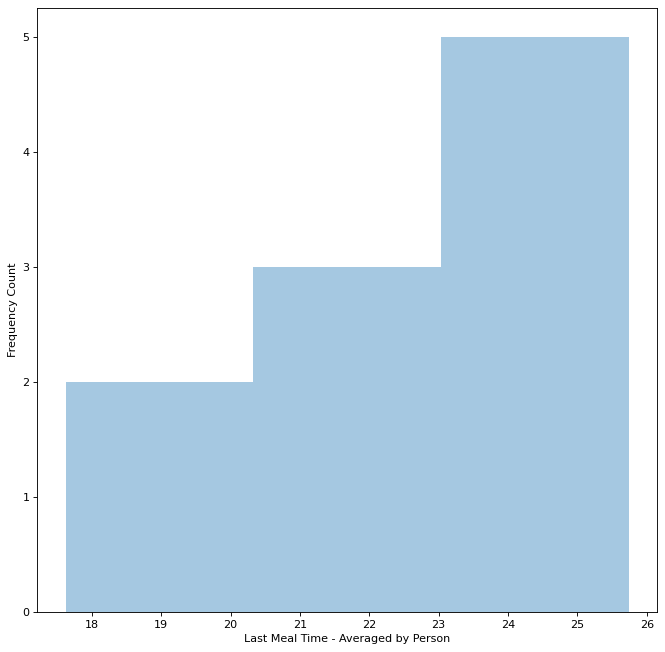

In [ ]:
dinner_avg_histplot('data/output/public_basline_usable_expanded.pickle','unique_code', 'date', 'local_time')

In [ ]:
# export
def dinner_sample_distplot(in_path, n, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the distplot for the dinner time from n participants that will be randomly selected with replacement.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.
        - n (int): the number of participants that will be randomly selected in the output figure
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
        
    Return:\n
        - None
        
    Requirements:\n
        - food_type
        
    """
    df = universal_key(in_path)
    df = df[df['food_type'].isin(['f','b'])]
    dinner_by_person = pd.DataFrame(df.groupby([identifier, date_col])\
                                       [time_col].max())
    fig, ax = plt.subplots(1, 1, figsize = (10, 10), dpi=80)
    
    print('Plotting distplots for the following users:')
    for i in np.random.choice(np.array(list(set(dinner_by_person.index.droplevel(date_col)))), n):
        print(i)
        sns.distplot(dinner_by_person[time_col].loc[i])

read the pickle file successfully.
Plotting distplots for the following users:
alqt45631586569
alqt45631586569
alqt21525720972
alqt16675467779
alqt16675467779


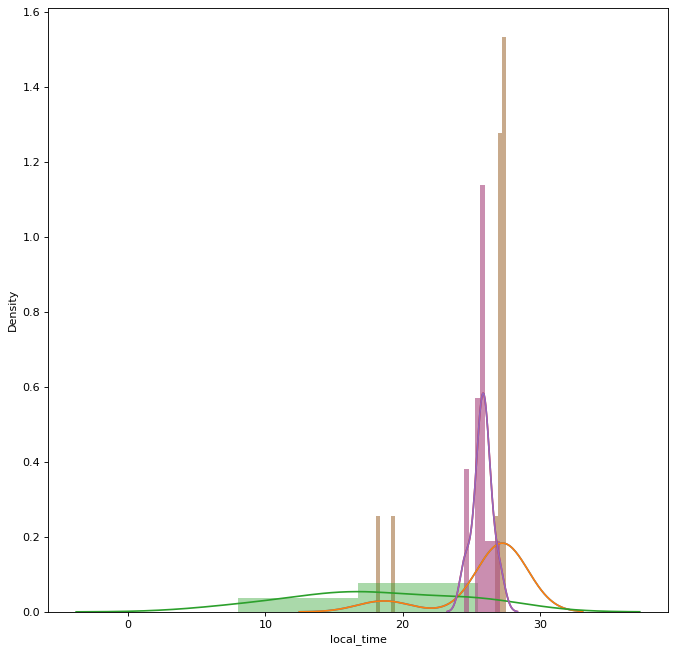

In [ ]:
dinner_sample_distplot('data/output/public_intervention_usable.pickle',5,'unique_code', 'date', 'local_time')

In [ ]:
# export
def swarmplot(in_path, max_loggings, identifier, date_col, time_col):
    """
    Description:\n
       This function plots the swarmplot the participants from the in_path file.\n
    
    Input:\n
        - in_path (str, pandas df): input path, file in pickle, csv or panda dataframe format.\n
        - max_loggings (int): the max number of loggings to be plotted for each participants, loggings will be randomly selected.
        - identitfier(str) : participants' unique identifier such as id, name, etc.
        - date_col(str) : the column that represents the dates.
        - time_col(str) : the column that represents the float time.
    Return:\n
        - None
        
    Requirements:\n
        in_path file must have the following columns:\n
            - food_type\n
    """
    
    df = universal_key(in_path)
    
    def subsamp_by_cond(alldat):
        alld = []
        for apart in alldat[identifier].unique():
            dat = alldat[alldat[identifier]==apart]
            f_n_b = dat.query('food_type in ["f", "b"]')
            n = min([f_n_b.shape[0], max_loggings])
            sub = f_n_b.sample(n = n, axis=0)
            alld.append(sub)
        return pd.concat(alld)

    sample = subsamp_by_cond(df)
    fig, ax = plt.subplots(1, 1, figsize = (10, 30), dpi=300)


    ax.axvspan(3.5,6, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    ax.axvspan(18,28.5, alpha=0.2, color=[0.8, 0.8, 0.8]  )
    # plt.xlabel('Hour of day')
    plt.xticks([4,8,12,16,20,24,28],[4,8,12,16,20,24,4])
    plt.title('Food events for TRE group')

    ax = sns.swarmplot(data = sample, 
                  y = identifier, 
                  x = time_col, 
                  dodge = True, 
                  color = sns.xkcd_rgb['golden rod'],
                 )

    ax.set(
        facecolor = 'white', 
        title = 'Food events (F & B)',
        ylabel = 'Participant',
        xlabel = 'Local time of consumption'
    )

read the pickle file successfully.


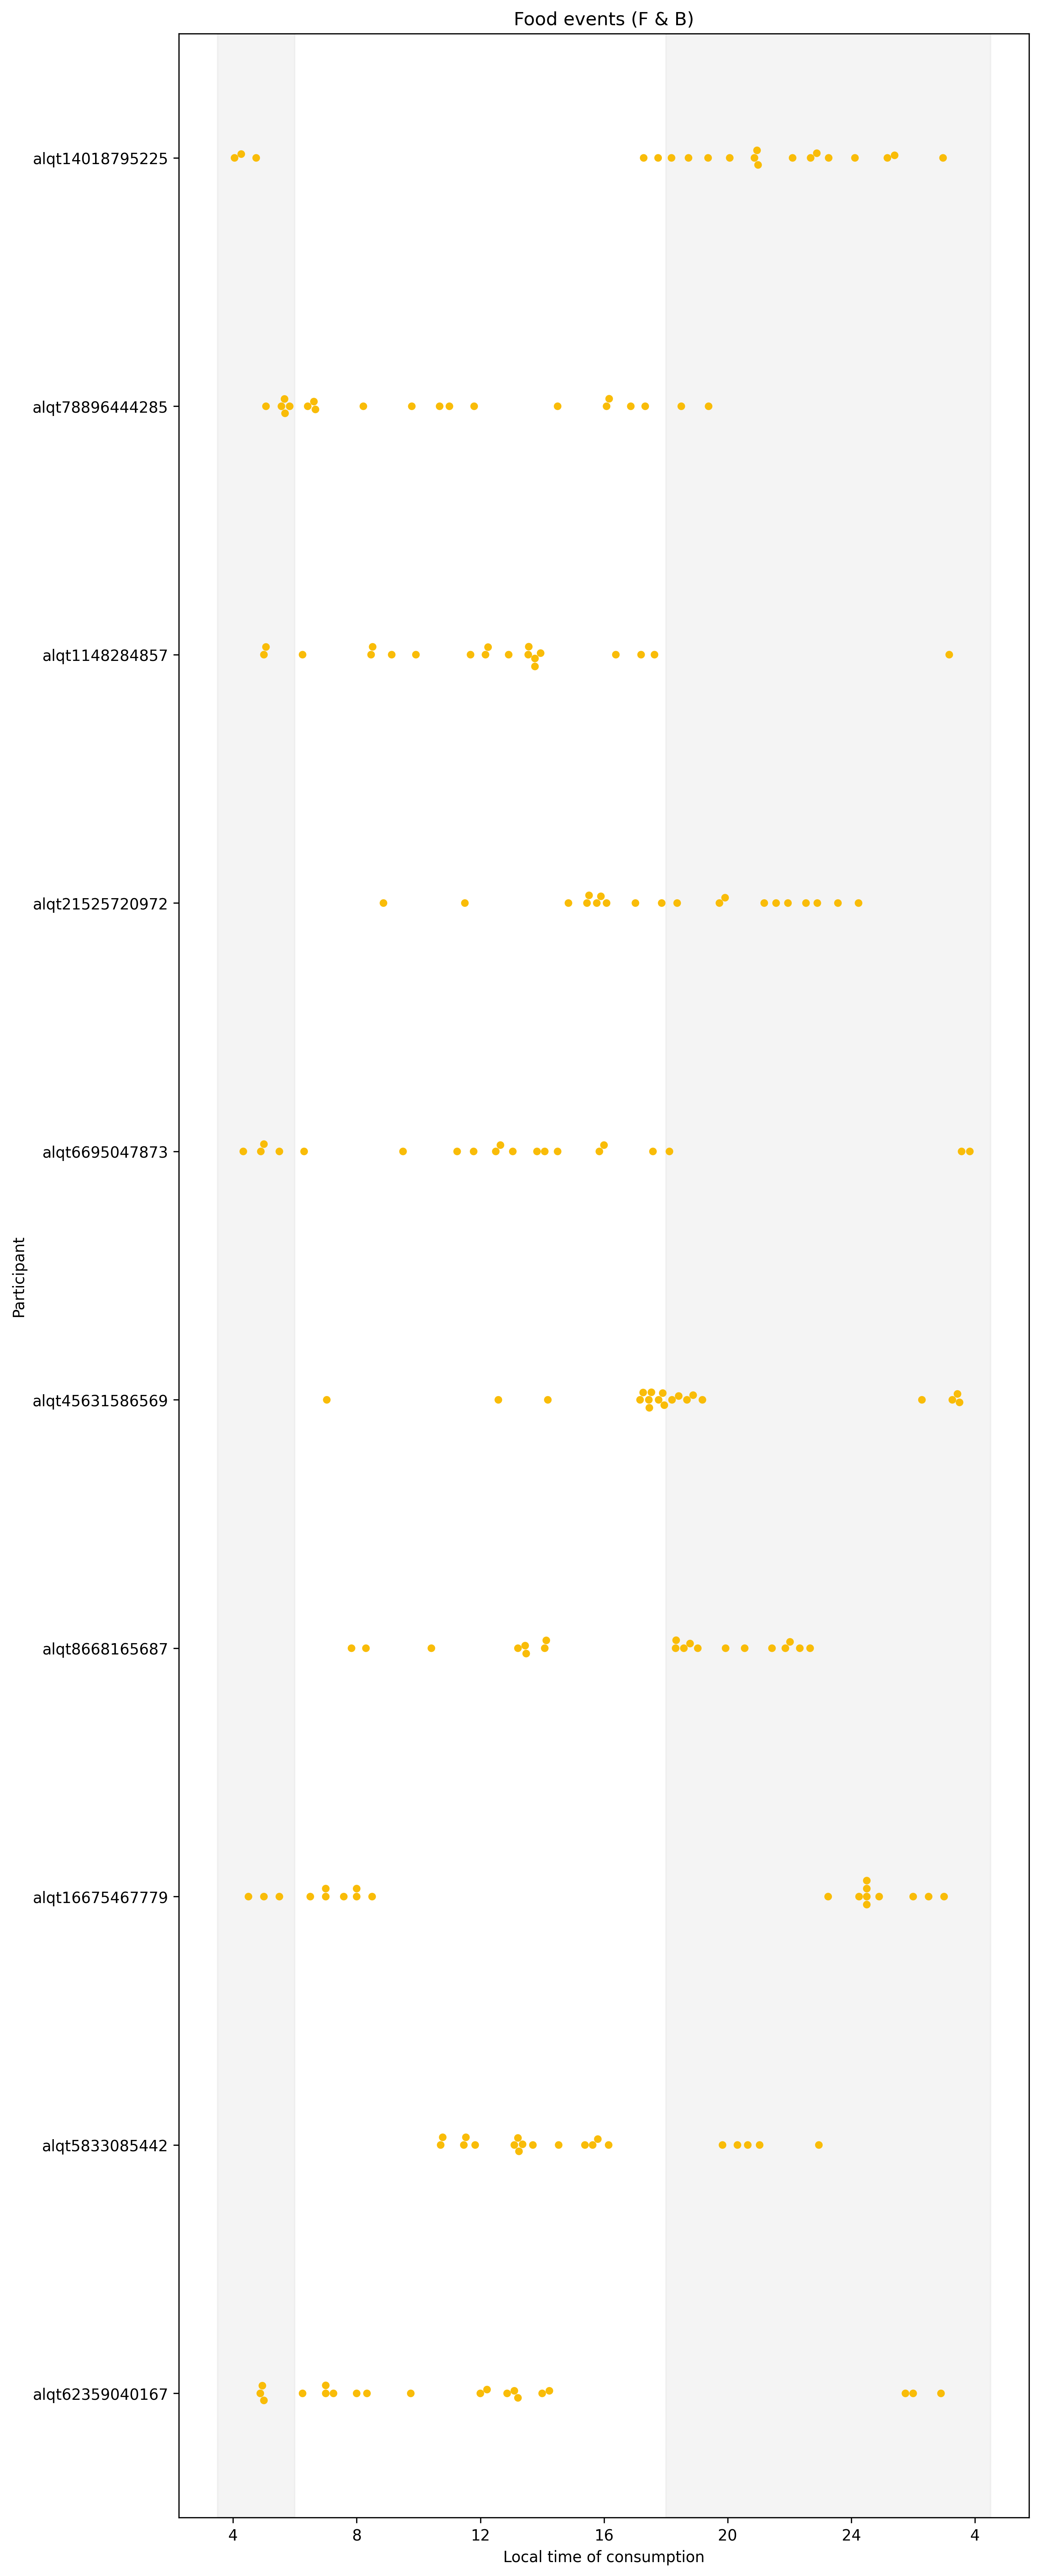

In [ ]:
swarmplot('data/output/public.pickle', 20,'unique_code', 'date', 'local_time')

In [ ]:
# export
class FoodParser():
    """
    A class that reads in food loggings from the app. Used as helper function for the function convert_loggings().
    """

    def __init__(self):
        # self.__version__ = '0.1.9'
        self.wnl = WordNetLemmatizer()
        # self.spell = SpellChecker()
        return

    ################# Read in Annotations #################
    def process_parser_keys_df(self, parser_keys_df):
        parser_keys_df = parser_keys_df.query('food_type in ["f", "b", "m", "w", "modifier", "general", "stopword", "selfcare"]').reset_index(drop = True)

        # 1. all_gram_sets
        all_gram_set = []
        for i in range(1, 6):
            all_gram_set.append(set(parser_keys_df.query('gram_type == ' + str(i)).gram_key.values))

        # 2. food_type_dict
        food_type_dict = dict(zip(parser_keys_df.gram_key.values, parser_keys_df.food_type.values))

        # 3. food2tag
        def find_all_tags(s):
            tags = []
            for i in range(1, 8):
                if not isinstance(s['tag' + str(i)], str) and np.isnan(s['tag' + str(i)]):
                    continue
                tags.append(s['tag' + str(i)])
            return tags
        food2tags = dict(zip(parser_keys_df.gram_key.values, parser_keys_df.apply(find_all_tags, axis = 1)))
        return all_gram_set, food_type_dict, food2tags

    # def run_setup(self):
    #     setup_dict = {}
    #
    #     # Read parser_keys
    #     parser_keys_df = self.read_parser_keys()
    #     all_gram_set, food_type_dict, food2tags = self.process_parser_keys_df(parser_keys_df)
    #     # my_stop_words = combined_gram_set_df.query('food_type == "stopwords"').gram_key.values
    #
    #     # Read the correction history for fire-fighters
    #     # correction_dic = pickle.load(open(pkg_resources.resource_stream(__name__, "data/correction_dic.pickle"), 'rb'))
    #     correction_dic = pickle.load(pkg_resources.resource_stream(__name__, "data/correction_dic.pickle"))
    #
    #     setup_dict['all_gram_set'] = all_gram_set
    #     setup_dict['food_type_dict'] = food_type_dict
    #     setup_dict['my_stop_words'] = my_stop_words
    #     setup_dict['correction_dic'] = correction_dic
    #     return setup_dict

    def initialization(self):
        # 1. read in manually annotated file and bind it to the object
        parser_keys_df = pd.read_csv(pkg_resources.resource_stream(__name__, "/data/parser_keys.csv"))
        #parser_keys_df = pd.read_csv("data/parser_keys.csv")
        all_gram_set, food_type_dict, food2tags = self.process_parser_keys_df(parser_keys_df)
        correction_dic = pickle.load(pkg_resources.resource_stream(__name__, "/data/correction_dic.pickle"))
        #correction_dic = universal_key("data/correction_dic.pickle")
        self.all_gram_set = all_gram_set
        self.food_type_dict = food_type_dict
        self.correction_dic = correction_dic
        self.tmp_correction = {}
        # setup_dict = self.run_setup()
        # self.my_stop_words = setup_dict['my_stop_words']
        # self.gram_mask = gram_mask
        # self.final_measurement = final_measurement

        # 2. Load common stop words and bind it to the object
        stop_words = stopwords.words('english')
        # Updated by Katherine August 23rd 2020
        stop_words.remove('out') # since pre work out is a valid beverage name
        stop_words.remove('no')
        stop_words.remove('not')
        self.stop_words = stop_words
        return

    ########## Pre-Processing ##########
    # Function for removing numbers
    def handle_numbers(self, text):
        clean_text = text
        clean_text = re.sub('[0-9]+\.[0-9]+', '' , clean_text)
        clean_text = re.sub('[0-9]+', '' , clean_text)
        clean_text = re.sub('\s\s+', ' ', clean_text)
        return clean_text

    # Function for removing punctuation
    def drop_punc(self, text):
        clean_text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        return clean_text

    # Remove normal stopwords
    def remove_stop(self, my_text):
        text_list = my_text.split()
        return ' '.join([word for word in text_list if word not in self.stop_words])

    # def remove_my_stop(self, text):
    #     text_list = text.split()
    #     return ' '.join([word for word in text_list if word not in self.my_stop_words])

    def pre_processing(self, text):
        text = text.lower()
        # return self.remove_my_stop(self.remove_stop(self.handle_numbers(self.drop_punc(text)))).strip()
        return self.remove_stop(self.handle_numbers(self.drop_punc(text))).strip()

    ########## Handle Format ##########
    def handle_front_mixing(self, sent, front_mixed_tokens):
        # print(sent)
        cleaned_tokens = []
        for t in sent.split():
            if t in front_mixed_tokens:
                number = re.findall('\d+[xX]*', t)[0]
                for t_0 in t.replace(number, number + ' ').split():
                    cleaned_tokens.append(t_0)
            else:
                cleaned_tokens.append(t)
        return ' '.join(cleaned_tokens)

    def handle_x2(self, sent, times_x_tokens):
        # print(sent)
        for t in times_x_tokens:
            sent = sent.replace(t, ' ' + t.replace(' ', '').lower() + ' ')
        return ' '.join([s for s in sent.split() if s != '']).strip()

    def clean_format(self, sent):
        return_sent = sent

        # Problem 1: 'front mixing'
        front_mixed_tokens = re.findall('\d+[^\sxX]+', sent)
        if len(front_mixed_tokens) != 0:
            return_sent = self.handle_front_mixing(return_sent, front_mixed_tokens)

        # Problem 2: 'x2', 'X2', 'X 2', 'x 2'
        times_x_tokens = re.findall('[xX]\s*?\d', return_sent)
        if len(times_x_tokens) != 0:
            return_sent = self.handle_x2(return_sent, times_x_tokens)
        return return_sent

    ########## Handle Typo ##########
    def fix_spelling(self, entry, speller_check = False):
        result = []
        for token in entry.split():
            # Check known corrections
            if token in self.correction_dic.keys():
                token_alt = self.wnl.lemmatize(self.correction_dic[token])
            else:
                if speller_check and token in self.tmp_correction.keys():
                    token_alt = self.wnl.lemmatize(self.tmp_correction[token])
                elif speller_check and token not in self.food_type_dict.keys():
                    token_alt = self.wnl.lemmatize(token)
                    # token_alt = self.wnl.lemmatize((self.spell.correction(token)))
                    self.tmp_correction[token] = token_alt
                else:
                    token_alt = self.wnl.lemmatize(token)
            result.append(token_alt)
        return ' '.join(result)

    ########### Combine all cleaning ##########
    def handle_all_cleaning(self, entry):
        cleaned = self.pre_processing(entry)
        cleaned = self.clean_format(cleaned)
        cleaned = self.fix_spelling(cleaned)
        return cleaned

    ########## Handle Gram Matching ##########
    def parse_single_gram(self, gram_length, gram_set, gram_lst, sentence_tag):
        food_lst = []
        # print(gram_length, gram_lst, sentence_tag)
        for i in range(len(gram_lst)):
            if gram_length > 1:
                curr_word = ' '.join(gram_lst[i])
            else:
                curr_word = gram_lst[i]
            # print(curr_word, len(curr_word))
            if curr_word in gram_set and sum([t != 'Unknown' for t in sentence_tag[i: i+gram_length]]) == 0:
                # Add this founded food to the food list
                # food_counter += 1
                sentence_tag[i: i+gram_length] = str(gram_length)
                # tmp_dic['food_'+ str(food_counter)] = curr_word
                food_lst.append(curr_word)
                # print('Found:', curr_word)
        return food_lst

    def parse_single_entry(self, entry, return_sentence_tag = False):
        # Pre-processing and Cleaning
        cleaned = self.handle_all_cleaning(entry)
        # print(cleaned)

        # Create tokens and n-grams
        tokens = nltk.word_tokenize(cleaned)
        bigram = list(nltk.ngrams(tokens, 2)) if len(tokens) > 1 else None
        trigram = list(nltk.ngrams(tokens, 3)) if len(tokens) > 2 else None
        quadgram = list(nltk.ngrams(tokens, 4)) if len(tokens) > 3 else None
        pentagram = list(nltk.ngrams(tokens, 5)) if len(tokens) > 4 else None
        all_gram_lst = [tokens, bigram, trigram, quadgram, pentagram]

        # Create an array of tags
        sentence_tag = np.array(['Unknown'] * len(tokens))
        # for i in range(len(sentence_tag)):
        #     if tokens[i] in self.final_measurement:
        #         sentence_tag[i] = 'MS'

        all_food = []
        food_counter = 0
        for gram_length in [5, 4, 3, 2, 1]:
            if len(tokens) < gram_length:
                continue
            tmp_food_lst = self.parse_single_gram(gram_length,
                                                self.all_gram_set[gram_length - 1],
                                                all_gram_lst[gram_length - 1],
                                                sentence_tag)
            all_food += tmp_food_lst
        # print(sentence_tag)
        if return_sentence_tag:
            return all_food, sentence_tag
        else:
            return all_food

    def parse_food(self, entry, return_sentence_tag = False):
        result = []
        unknown_tokens = []
        num_unknown = 0
        num_token = 0
        for w in entry.split(','):
            all_food, sentence_tag = self.parse_single_entry(w, return_sentence_tag)
            result += all_food
            if len(sentence_tag) > 0:
                num_unknown += sum(np.array(sentence_tag) == 'Unknown')
                num_token += len(sentence_tag)
                cleaned = nltk.word_tokenize(self.handle_all_cleaning(w))

                # Return un-catched tokens, groupped into sub-sections
                tmp_unknown = ''
                for i in range(len(sentence_tag)):
                    if sentence_tag[i] == 'Unknown':
                        # unknown_tokens.append(cleaned[i])
                        tmp_unknown += (' ' + cleaned[i])
                        if i == len(sentence_tag) - 1:
                            unknown_tokens.append(tmp_unknown)
                    elif tmp_unknown != '':
                        unknown_tokens.append(tmp_unknown)
                        tmp_unknown = ''
        # for i in range(len(result)):
        #     if result[i] in self.gram_mask.keys():
        #          result[i] = self.gram_mask[result[i]]
        if return_sentence_tag:
            return result, num_token, num_unknown, unknown_tokens
        else:
            return result

    def find_food_type(self, food):
        if food in self.food_type_dict.keys():
            return self.food_type_dict[food]
        else:
            return 'u'

    ################# DataFrame Functions #################
    def expand_entries(self, df):
        assert 'desc_text' in df.columns, '[ERROR!] Required a column of "desc_text"!!'

        all_entries = []
        for idx in range(df.shape[0]):
            curr_row = df.iloc[idx]
            logging = curr_row.desc_text
            tmp_dict = dict(curr_row)
            if ',' in logging:
                for entry in logging.split(','):
                    tmp_dict = tmp_dict.copy()
                    tmp_dict['desc_text'] = entry
                    all_entries.append(tmp_dict)
            else:
                tmp_dict['desc_text'] = logging
                all_entries.append(tmp_dict)

        return pd.DataFrame(all_entries)
